In [0]:
!pip install overpy
!pip install gmplot

     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for overpy: filename=overpy-0.4-cp36-none-any.whl size=45771 sha256=1d473ae9c8c880944fc31ae667cb0eb18c968f819ff8061ebeb39b879621764d
  Stored in directory: /root/.cache/pip/wheels/10/53/c2/e6b6f97e7bb419193bd3aafbe38628666f0f93a1cec9dc521d
Successfully built overpy
     |████████████████████████████████| 122kB 3.5MB/s 
  Created wheel for gmplot: filename=gmplot-1.2.0-cp36-none-any.whl size=143765 sha256=b606aae3e76dfbd32faabf0a4e3069c36c3ee05df94ba82a46e1a06765c97599
  Stored in directory: /root/.cache/pip/wheels/81/6a/76/4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot


In [ ]:
import os
import copy
import json
import math
import overpy
import pandas as pd
from gmplot import gmplot
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.datasets.samples_generator import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import numpy as np
import mpl_toolkits
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# 1. Use Overpass API to get all Point of Interest

In [0]:
#  Jaipur - 26.84, 75.71, 26.98, 75.90
#  Delhi - 28.488, 77.103, 28.843, 77.390
#  Mumbai - 18.898986, 72.780002, 19.280442, 72.985434
#  la 33.820973, -118.387737, 34.167668, -118.085683
#  london-1 - 51.3674, -0.3059, 51.6442, 0.089625
# delhi-mini - 28.5825, 77.1645, 28.7004, 77.3144

In [30]:
city_name = 'delhi-1'

In [0]:
api = overpy.Overpass()
result = api.query("node(  28.488, 77.103, 28.843, 77.390  );out;")

In [0]:
result.nodes[0]

<overpy.Node id=16173236 lat=28.6141793 lon=77.2022662>

In [0]:
len(result.nodes)

314426

In [0]:
result.nodes[10], result.nodes[113].tags

(<overpy.Node id=249237060 lat=28.6743670 lon=77.2168688>, {})

In [0]:
tags = []
for i in result.nodes:
    if len(i.tags) is not 0:
        i_tags = i.tags
        i_tags['node_id'] = i.id
        i_tags['lat'] = float(i.lat)
        i_tags['lon'] = float(i.lon)
        tags.append(i.tags)
        
        
print(len(tags))
tags[3]

5140


{'highway': 'traffic_signals',
 'lat': 28.6298938,
 'lon': 77.2194853,
 'node_id': 249783293}

In [0]:
df = pd.DataFrame(tags)
df.head(10)

,ISO3166-2,access,addr:area,addr:city,addr:country,addr:district,addr:full,addr:housename,addr:housenumber,addr:place,addr:postcode,addr:state,addr:street,addr:subdistrict,addr:suburb,addr:unit,address,admin_level,aeroway,air_conditioning,alcohol,alt_name,alt_name:ar,alt_name:de,alt_name:en,alt_name:fr,alt_name:hi,alt_name:nl,alt_name:vi,amenity,amenity_1,area,artwork_type,atm,backrest,barrier,beauty,bench,bicycle,bicycle_parking,...,social_facility:for,source,source:name:oc,sport,stars,start_date,station,studio,subway,supervised,sustenance,sym,tables,tactile_paving,takeaway,target,theatre:type,to,toilets,toilets:access,toilets:disposal,toilets:wheelchair,tourism,tower:type,traffic_calming,traffic_signals,traffic_signals:direction,train,unisex,url,usage,vending,waste,website,wheelchair,wifi,wikidata,wikimedia_commons,wikipedia,wikipedia:en
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,نيودلهي,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q987,NaN,en:New Delhi,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,signal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [0]:
df.shape

(5140, 390)

In [31]:
file_name = "data/" + city_name + '-overpass.csv'
df.to_csv(file_name, index=False)
print(file_name)

data/delhi-1-overpass.csv


Aakash Jhawar
https://aakashjhawar.github.io

# 2. Select columns which are usefull

In [0]:
df = df[['node_id', 'lat', 'lon', 'name', 'amenity']]
print(df.shape)
df.head()

(5140, 5)


,node_id,lat,lon,name,amenity
0,16173236,28.614179,77.202266,New Delhi,NaN
1,246518180,28.601933,77.180677,NaN,NaN
2,246518184,28.606088,77.187424,NaN,NaN
3,249783293,28.629894,77.219485,NaN,NaN
4,249783302,28.631410,77.216760,NaN,NaN


In [0]:
df_nan = df.copy()
df = df.dropna(subset=['node_id', 'lat', 'amenity'])
print(df.shape)
df.head()

(1242, 5)


,node_id,lat,lon,name,amenity
29,280741143,28.647250,77.194235,Axis Bank,bank
46,308894803,28.606946,77.229919,NaN,restaurant
58,309861440,28.598375,77.185421,US Embassy School New Delhi,school
70,355436031,28.645835,77.172330,NaN,post_box
71,355436037,28.645887,77.172379,ICICI Bank,atm


In [32]:
file_name = "data/" + city_name + '-amenity.csv'
df.to_csv(file_name, index=False)
print(file_name)

data/delhi-1-amenity.csv


In [35]:
amenities = list(set(df['amenity']))
print(len(amenities))
print(amenities)

51
['food_court', 'drinking_water', 'ice_cream', 'nursing_home', 'cafe', 'dentist', 'nightclub', 'post_box', 'Drinking_Water', 'fire_station', 'public_building', 'payment_centre', 'public_bath', 'hospital', 'university', 'internet_cafe', 'pub', 'marketplace', 'clinic', 'money_transfer', 'embassy', 'bar', 'restaurant', 'bus_station', 'kindergarten', 'post_office', 'disused', 'courthouse', 'community_centre', 'pharmacy', 'theatre', 'taxi', 'bank', 'school', 'toilets', 'police', 'fuel', 'driving_school', 'place_of_worship', 'parking', 'club', 'fast_food', 'studio', 'atm', 'music_school', 'crematorium', 'library', 'college', 'memorial', 'doctors', 'cinema']


In [0]:
remove_amenity =  [
    'arts_centre',
    "Ayurvedic Hospital",
    "baby_hatch",
    "bench",
    "bicycle_parking",
    "bicycle_rental",
    "bicycle_repair_station",
    "bureau_de_change",
    "car_rental",
    "car_wash",
    "charging_station",
    "fountain",
    "grave_yard",
    "House",
    "language_school",
    "meditation_centre",
    "motorcycle_parking",
    "orphanage",
    "payment_terminal",
    "photo_booth",
    "post_depot",
    "recycling",
    "shelter",
    "social_centre",
    "social_facility",
    "telephone",
    "training",
    "tuition",
    "vending_machine",
    "veterinary",
    "waste_basket",
    "waste_disposal",
    "waste_transfer_station",
    "water_point",
    "weighbridge",
]

In [0]:
df_nan_all = df.copy()
for val in remove_amenity:
    df = df[df.amenity != val]

print(df.shape)
df.head()

(1138, 5)


,node_id,lat,lon,name,amenity
29,280741143,28.647250,77.194235,Axis Bank,bank
46,308894803,28.606946,77.229919,NaN,restaurant
58,309861440,28.598375,77.185421,US Embassy School New Delhi,school
70,355436031,28.645835,77.172330,NaN,post_box
71,355436037,28.645887,77.172379,ICICI Bank,atm


In [33]:
file_name = "data/" + city_name + '-reduced_amenity.csv'
df.to_csv(file_name, index=False)
print(file_name)

data/delhi-1-reduced_amenity.csv


# 3. Analyze coordinates using Agglomerative Hierarchical Clustering

In [0]:
data = df[['lat', 'lon']]
data.head()

,lat,lon
29,28.647250,77.194235
46,28.606946,77.229919
58,28.598375,77.185421
70,28.645835,77.172330
71,28.645887,77.172379


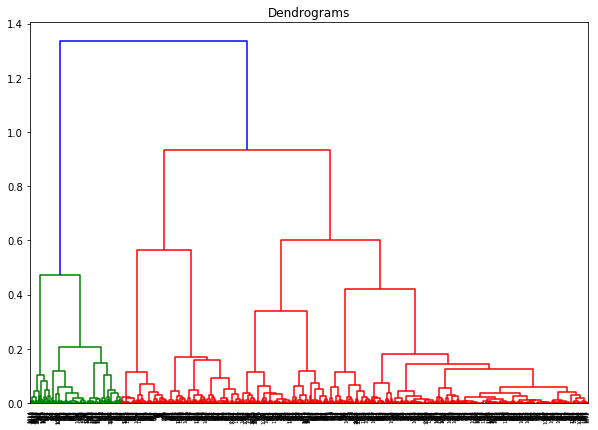

In [0]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [0]:
X = data[['lat', 'lon']].values

In [0]:
# def plot_elbow(kmean, X):
#     centroids = [k.cluster_centers_ for k in kmean]
#     D_k = [cdist(X, center, 'euclidean') for center in centroids]
#     dist = [np.min(D,axis=1) for D in D_k]

#     # Total with-in sum of square
#     wcss = [sum(d**2) for d in dist]
#     tss = sum(pdist(X)**2)/X.shape[0]
#     bss = tss-wcss

#     plt.subplots(nrows=1, ncols=1, figsize=(8,8))
#     ax = plt.subplot(1, 1, 1)
#     ax.plot(Ks, bss/tss*100, 'b*-')
#     plt.grid(True)
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Percentage of variance explained (%)')
#     plt.title('Elbow for KMeans clustering')
#     plt.show()

# plot_elbow(kmean, X)

# 4. Plot coordinates on Map using gmplot

In [0]:
min_lat, max_lat, min_lon, max_lon = min(data['lat']), max(data['lat']), min(data['lon']), max(data['lon'])
## Create empty map with zoom level 16
mymap = gmplot.GoogleMapPlotter(
                      min_lat + (max_lat - min_lat) / 2, 
                      min_lon + (max_lon - min_lon) / 2, 
                      16)
min_lat, max_lat, min_lon, max_lon

(28.5825971, 28.7002715, 77.1652197, 77.3142748)

In [0]:
for i in range(data.shape[0]):
    mymap.scatter([data.iloc[i]['lat']], [data.iloc[i]['lon']], 'red', size=50, marker=False)

In [34]:
file_name = "data/" + city_name + '-scatter.html'
mymap.draw(file_name)
print(file_name)

data/delhi-1-scatter.html


Aakash Jhawar https://aakashjhawar.github.io